# Big Data Processing

In [2]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, monotonically_increasing_id
from pyspark.ml.feature import StringIndexer, VectorAssembler, StandardScaler
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import BinaryClassificationEvaluator
import pandas as pd

# Step 1: Start Spark session
spark = SparkSession.builder \
    .appName("FraudDetectionModelWithSplitMerge") \
    .master("local[*]") \
    .config("spark.driver.memory", "4g") \
    .config("spark.kryoserializer.buffer", "512m") \
    .config("spark.kryoserializer.buffer.max", "1g") \
    .getOrCreate()

# Step 2: Load Excel file using pandas
df_pd = pd.read_excel("/Users/anand/Downloads/transactions_train_Updated.xlsx", sheet_name="transactions_train")
df_spark = spark.createDataFrame(df_pd)

# Step 3: Add synthetic primary key
df_spark = df_spark.withColumn("transaction_id", monotonically_increasing_id())

# Step 4: Split and save
df_spark.select("transaction_id", "step", "type", "amount") \
    .write.csv("transaction_metadata.csv", header=True, mode="overwrite")

df_spark.select("transaction_id", "nameOrig", "oldbalanceOrig", "newbalanceOrig") \
    .write.csv("origin_accounts.csv", header=True, mode="overwrite")

df_spark.select("transaction_id", "nameDest", "oldbalanceDest", "newbalanceDest", "isFraud") \
    .write.csv("destination_accounts.csv", header=True, mode="overwrite")

# Step 5: Recombine
df = df_spark.drop("nameOrig", "nameDest")

# Step 6: Feature engineering
df = df.withColumn("balanceOrigDiff", col("oldbalanceOrig") - col("newbalanceOrig"))
df = df.withColumn("balanceDestDiff", col("newbalanceDest") - col("oldbalanceDest"))

# Step 7: Prepare features
indexer = StringIndexer(inputCol="type", outputCol="type_index")
features = [
    "type_index", "amount", "oldbalanceOrig", "newbalanceOrig",
    "oldbalanceDest", "newbalanceDest", "balanceOrigDiff", "balanceDestDiff"
]
assembler = VectorAssembler(inputCols=features, outputCol="features_vec")
scaler = StandardScaler(inputCol="features_vec", outputCol="features")

# Step 8: Train classifier
rf = RandomForestClassifier(labelCol="isFraud", featuresCol="features", numTrees=20)

# Step 9: Pipeline and training
pipeline = Pipeline(stages=[indexer, assembler, scaler, rf])
train, test = df.randomSplit([0.7, 0.3], seed=42)
model = pipeline.fit(train)

# Step 10: Evaluate
predictions = model.transform(test)
evaluator = BinaryClassificationEvaluator(labelCol="isFraud")
auc = evaluator.evaluate(predictions)
print(f"AUC-ROC: {auc:.4f}")


AUC-ROC: 0.9642


# Exploratory Data Analysis (EDA)

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load a sample from the dataset to avoid performance issues
file_path = "/Users/anand/Downloads/transactions_train_Updated.xlsx"  # change this to your full path
df = pd.read_excel(file_path, sheet_name="transactions_train")

# Display basic information
print("Dataset shape:", df.shape)
print("Missing values:\n", df.isnull().sum())
print("Fraud class distribution:\n", df["isFraud"].value_counts())
print("Data types:\n", df.dtypes)

# Summary statistics
print("\nSummary Statistics:\n", df.describe(include='all'))



Dataset shape: (600000, 10)
Missing values:
 step              0
type              0
amount            0
nameOrig          0
oldbalanceOrig    0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
dtype: int64
Fraud class distribution:
 0    599639
1       361
Name: isFraud, dtype: int64
Data types:
 step                int64
type               object
amount            float64
nameOrig           object
oldbalanceOrig    float64
newbalanceOrig    float64
nameDest           object
oldbalanceDest    float64
newbalanceDest    float64
isFraud             int64
dtype: object

Summary Statistics:
                  step      type        amount     nameOrig  oldbalanceOrig  \
count   600000.000000    600000  6.000000e+05       600000    6.000000e+05   
unique            NaN         5           NaN       599918             NaN   
top               NaN  CASH_OUT           NaN  C1708422782             NaN   
freq              NaN    212756           

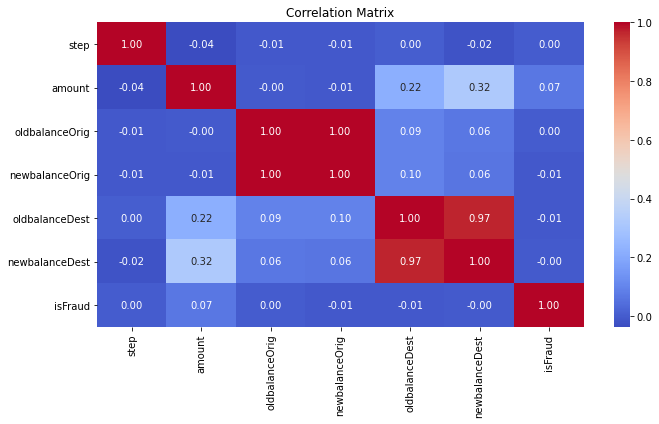

In [9]:
# Correlation matrix
plt.figure(figsize=(10, 6))
numeric_corr = df.select_dtypes(include='number').corr()
sns.heatmap(numeric_corr, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Matrix")
plt.tight_layout()
plt.show()


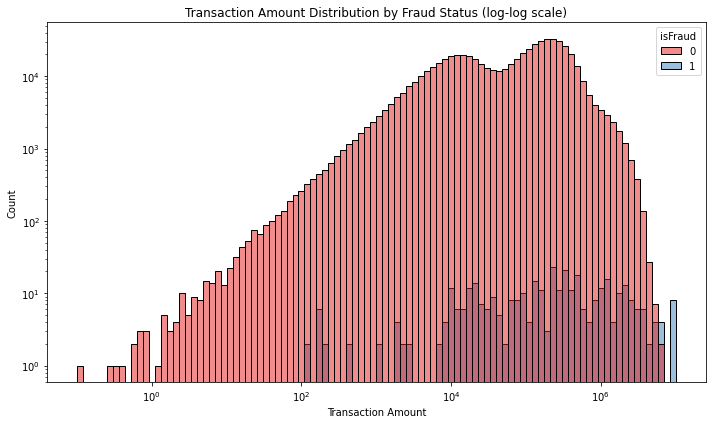

In [5]:
# Transaction Amount Distribution by Fraud Status
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x="amount", hue="isFraud", bins=100, log_scale=(True, True), kde=False, palette="Set1")
plt.title("Transaction Amount Distribution by Fraud Status (log-log scale)")
plt.xlabel("Transaction Amount")
plt.ylabel("Count")
plt.tight_layout()
plt.show()




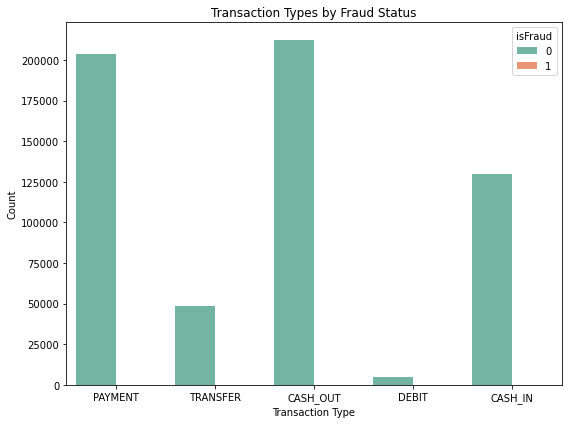

In [6]:
# Count of transaction types by fraud status
plt.figure(figsize=(8, 6))
sns.countplot(data=df, x="type", hue="isFraud", palette="Set2")
plt.title("Transaction Types by Fraud Status")
plt.xlabel("Transaction Type")
plt.ylabel("Count")
plt.tight_layout()
plt.show()



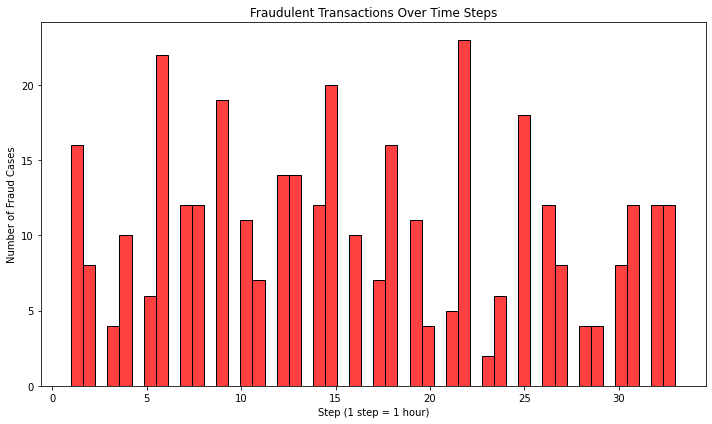

In [7]:
# Fraudulent Transactions Over Time Steps
plt.figure(figsize=(10, 6))
sns.histplot(data=df[df["isFraud"] == 1], x="step", bins=50, color="red")
plt.title("Fraudulent Transactions Over Time Steps")
plt.xlabel("Step (1 step = 1 hour)")
plt.ylabel("Number of Fraud Cases")
plt.tight_layout()
plt.show()



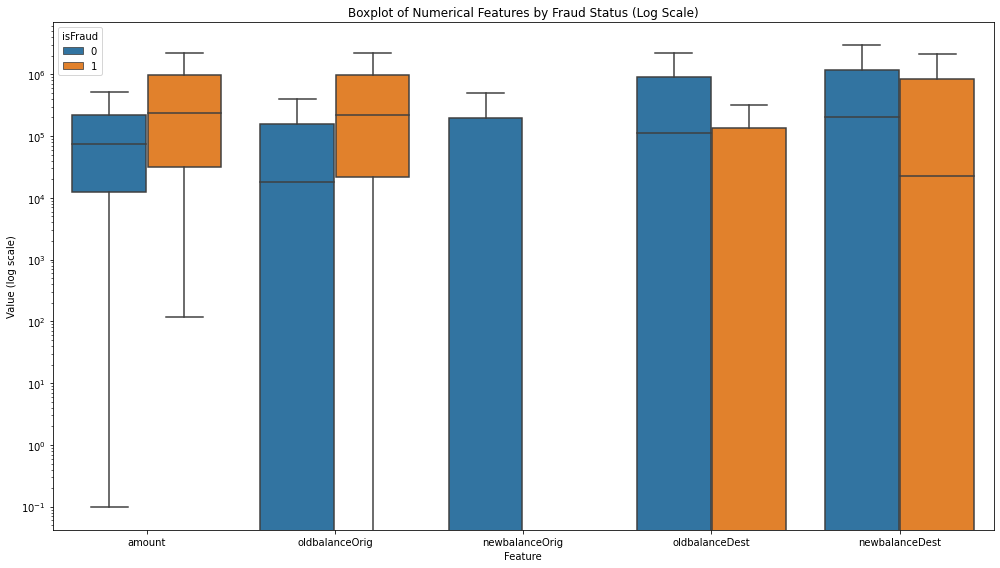

In [8]:
# Boxplot of numerical features by fraud status
numerical_features = [
    "amount", "oldbalanceOrig", "newbalanceOrig",
    "oldbalanceDest", "newbalanceDest"
]

df_melted = df.melt(id_vars="isFraud", value_vars=numerical_features)

plt.figure(figsize=(14, 8))
sns.boxplot(data=df_melted, x="variable", y="value", hue="isFraud", showfliers=False)
plt.yscale("log")
plt.title("Boxplot of Numerical Features by Fraud Status (Log Scale)")
plt.xlabel("Feature")
plt.ylabel("Value (log scale)")
plt.tight_layout()
plt.show()